In [1]:
import numpy as np
import pandas as pd
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import matplotlib.colors
from sklearn.preprocessing import StandardScaler

In [2]:
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

C:\Users\pars iran\AppData\Local\Temp\ipykernel_13368\3912264495.py:1: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))


In [7]:
class LinearWTASOM:
    def __init__(self, num_neurons, input_dim, learning_rate=0.1):
        np.random.seed(0)
        self.num_neurons = num_neurons
        self.input_dim = input_dim
        self.learning_rate = learning_rate
        self.weights = np.random.rand(num_neurons, input_dim)
        
    def find_bmu(self, input_vector):
        distances = np.linalg.norm(self.weights - input_vector, axis=1)
        return np.argmin(distances)
    
    def update_weights(self, input_vector, bmu_idx):
        self.weights[bmu_idx] += self.learning_rate * (input_vector - self.weights[bmu_idx])
    
    def train(self, input_vectors, num_iterations):
        for iteration in range(num_iterations):
            for input_vector in input_vectors:
                bmu_idx = self.find_bmu(input_vector)
                self.update_weights(input_vector, bmu_idx)
    def predict(self, input_vector):
            bmu_idx = self.find_bmu(input_vector)
            return bmu_idx

In [8]:
def read_dataset(file_path):
    dataset = pd.read_csv(file_path)
    dataset.drop(columns=['Lat','Long'], inplace=True)
    columns_to_mean = dataset.columns[2:]
    data_avg = dataset.groupby('Country/Region', as_index=False)[columns_to_mean].mean()
    
    new_data = data_avg.drop(columns=['Country/Region'], inplace=False)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(new_data.values)
    return X_scaled, data_avg['Country/Region'] ,new_data

In [9]:
def cluster_dataset(file_path):
    X_scaled, country_names, data = read_dataset(file_path)
    dim = X_scaled.shape[1]
    wta_som = LinearWTASOM(num_neurons=4, input_dim=dim)
    wta_som.train(X_scaled, num_iterations=1000)
    country_labels = [wta_som.predict(x) for x in X_scaled]
    data['Labels'] = country_labels
    grouped = data.groupby('Labels')
    cluster_sums = grouped.sum().mean(axis=1)
    sorted_indices = cluster_sums.sort_values().index
    severity_labels = ["Low", "Medium", "High", "Very High"]
    index_to_severity = {index: severity_labels[i] for i, index in enumerate(sorted_indices)}
    data['Severity_Label'] = data['Labels'].apply(lambda x: index_to_severity[x])
    labels_df = pd.DataFrame({'country': country_names, 'label': data['Severity_Label']})
    world_with_labels = world.merge(labels_df, left_on='name', right_on='country')
    cluster_color_mapping = {'Low': 'green', 'Medium': 'yellow', 'High': 'orange', 'Very High': 'red'}
    cmap = matplotlib.colors.ListedColormap([cluster_color_mapping[i] for i in sorted(cluster_color_mapping.keys())])
    fig, ax = plt.subplots(1, 1, figsize=(15, 10))
    world_with_labels.plot(column='label', ax=ax, legend=True, categorical=True, cmap=cmap, edgecolor='black', linewidth=0.2, legend_kwds={'bbox_to_anchor': (1, 1)})
    ax.set_axis_off()
    plt.show()

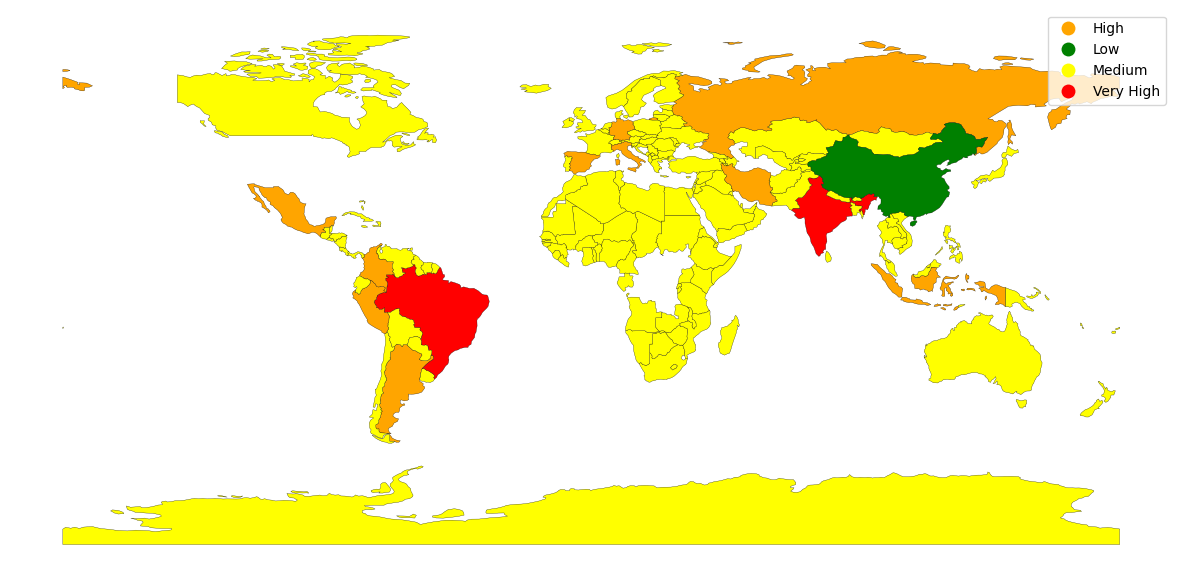

In [10]:
file_path = "dataset/time_series_covid19_deaths_global.csv"
cluster_dataset(file_path)

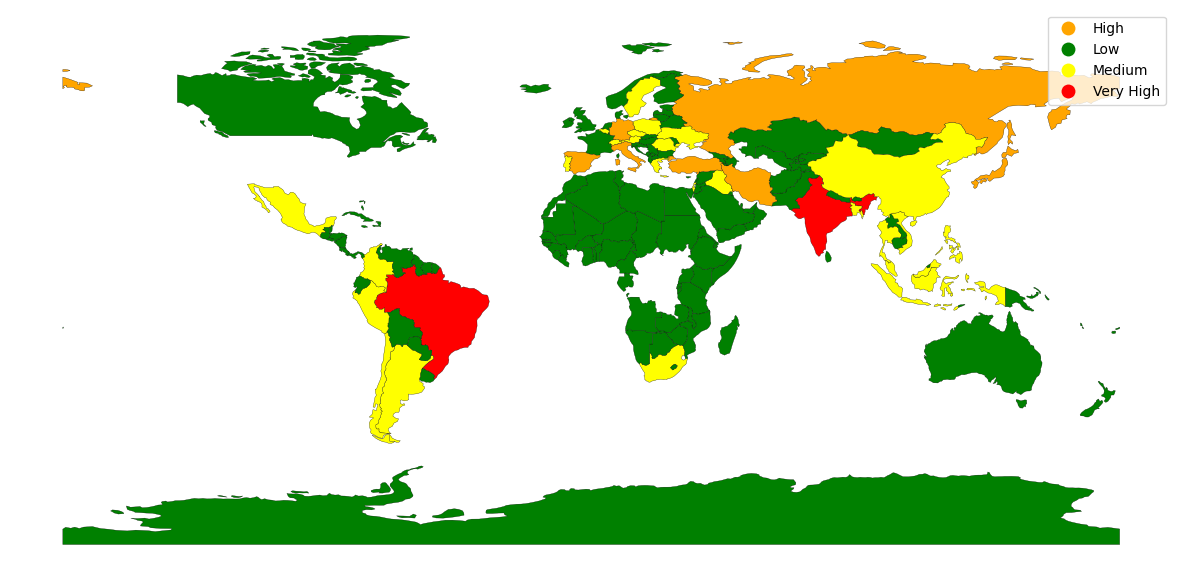

In [11]:
file_path = "dataset/time_series_covid19_confirmed_global.csv"
cluster_dataset(file_path)

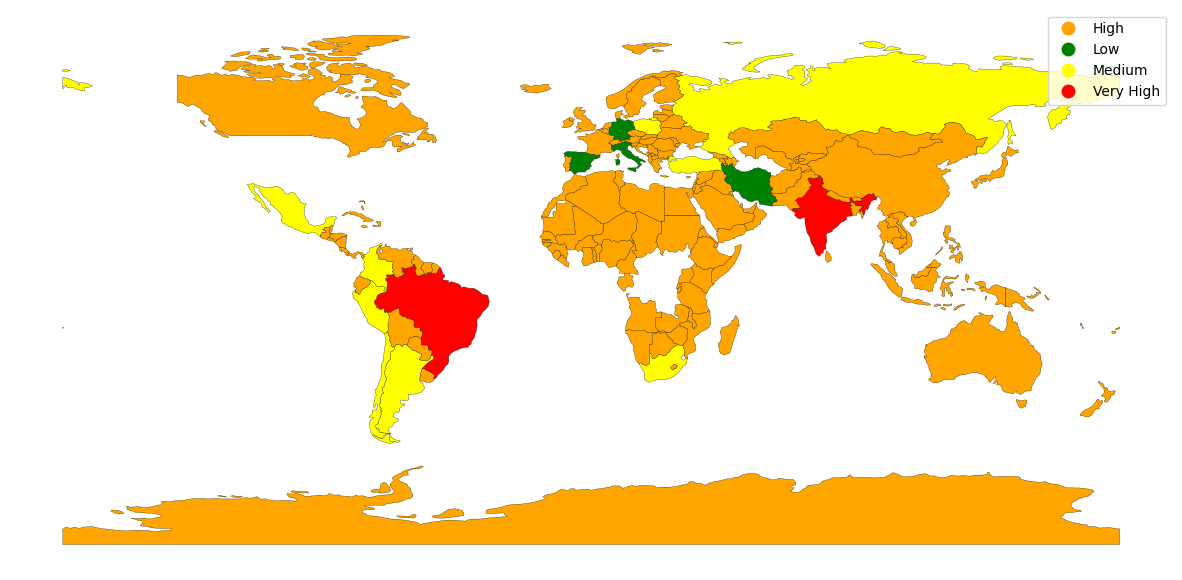

In [12]:
file_path = "dataset/time_series_covid19_recovered_global.csv"
cluster_dataset(file_path)